In [7]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
path="../../../ukb/data/"

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

#from OSGridConverter import grid2latlong

'''
Helper function to find out columns containing specific text
'''
def findcols(df,text):
    return [col for col in df.columns if text in col]

In [2]:
dis_vars=['n_eid','Age_Today','AD','PD','Diag_Date_AD','years_bef_diagAD','Age_Diag_AD',
                           'date_of_attending_assessment_centre_f53', 'age_when_attended_assessment_centre_f21003',
                           'EPIL','DIAB','CELIAC','CERVASC','CERVASC_bef','CERVASCALL_bef','EPIL_bef','DIAB_bef']

shap_vars2=['eid','sex_f31','Genotype','particulate_matter_air_pollution_pm25_2010_f24006','airpoll_24006','airpoll_24007',
       'mean_time_to_correctly_identify_matches_f20023','rounded_matches_f20023','urea_f30670',
       'number_of_treatmentsmedications_taken_f137','nitrogen_dioxide_air_pollution_2006_f24017',
       'sleeplessness_insomnia_f1200',
       'particulate_matter_air_pollution_pm25_absorbance_2010_f24007','mean_corpuscular_volume_f30040',
       'never_eat_eggs_dairy_wheat_sugar_f6144',
       'uk_east_coord',
       'parental_ad_status','qualifications_f6138',
       'uk_north_coord',
       'particulate_matter_air_pollution_pm10_2010_f24005',
       'time_spent_driving_f1090', 'creactive_protein_f30710',
       'alanine_aminotransferase_f30620','aspartate_aminotransferase_f30650',
       'answered_sexual_history_questions_f2129',
       'neutrophill_count_f30140', 'carer_support_indicators_f41214',
       'drive_faster_than_motorway_speed_limit_f1100',
       'history_of_psychiatric_care_on_admission_f41218',
       'particulate_matter_air_pollution_2510um_2010_f24008',
       'frequency_of_solariumsunlamp_use_f2277',
       'hand_grip_strength_left_f46', 'glycated_haemoglobin_hba1c_f30750',
       'frequency_of_tenseness_restlessness_in_last_2_weeks_f2070',
       'forced_expiratory_volume_in_1second_fev1_best_measure_f20150',
            'diabetes_diagnosed_by_doctor_f2443','overall_health_rating_f2178','processed_meat_intake_f1349',
           'number_of_daysweek_walked_10_minutes_f864','duration_of_walks_f874','sleep_duration_f1160','testosterone_f30850',
           'qualif_score','red_blood_cell_erythrocyte_distribution_width_f30070']



shapvars3=['difference_in_mobile_phone_use_compared_to_two_years_previously_f1140',
       'drive_faster_than_motorway_speed_limit_f1100',
       'drive_faster_than_motorway_speed_limit_f1100',
       'frequency_of_tenseness_restlessness_in_last_2_weeks_f2070',
       'met_minutes_per_week_for_walking_f22037',
       'never_eat_eggs_dairy_wheat_sugar_f6144',
       'nitrogen_dioxide_air_pollution_2006_f24017',
       'nitrogen_oxides_air_pollution_2010_f24004',
       'particulate_matter_air_pollution_2510um_2010_f24008',
       'particulate_matter_air_pollution_pm10_2007_f24019',
       'particulate_matter_air_pollution_pm10_2010_f24005',
       'particulate_matter_air_pollution_pm25_2010_f24006',
       'particulate_matter_air_pollution_pm25_absorbance_2010_f24007',
       'sleeplessness_insomnia_f1200', 'tea_intake_f1488',
       'time_spent_driving_f1090',
       'traffic_intensity_on_the_nearest_major_road_f24011',
       'usual_walking_pace_f924', 'water_intake_f1528']


shap_vars2=np.unique(np.concatenate([shap_vars2,shapvars3]))


shap_vars=['year_of_birth_f34','place_of_birth_in_uk_east_coordinate_f130',\
           'number_of_treatmentsmedications_taken_f137',
 'time_spent_using_computer_f1080',
 'sleeplessness_insomnia_f1200',
 'ever_had_samesex_intercourse_f2159',
 'longstanding_illness_disability_or_infirmity_f2188',
 'frequency_of_solariumsunlamp_use_f2277',
 'diabetes_diagnosed_by_doctor_f2443',
 'mothers_age_at_death_f3526',
 'never_eat_eggs_dairy_wheat_sugar_f6144',
 'mean_time_to_correctly_identify_matches_f20023',
 'particulate_matter_air_pollution_pm25_2010_f24006',
 'carer_support_indicators_f41214',
 'death',
 'parental_ad_status',
 'Genotype']

vars_analyse=['eid','Genotype','recent_feelings_of_depression_f20510','sleeplessness_insomnia_f1200','parental_ad_status',
      'particulate_matter_air_pollution_pm25_2010_f24006',
      'number_of_symbol_digit_matches_made_correctly_f20159','sex_f31',
      'type_of_special_diet_followed_f20086','ever_used_hormonereplacement_therapy_hrt_f2814'
      ]


qualmap={'None of the above':0,'Prefer not to answer':0,'O levels/GCSEs or equivalent':1,\
'NVQ or HND or HNC or equivalent':2,'NVQ or HND or HNC or equivalent' :3,\
'NVQ or HND or HNC or equivalent':4,'CSEs or equivalent':5,\
'Other professional qualifications eg: nursing, teaching':6,'A levels/AS levels or equivalent':7,\
'College or University degree':8 }

In [3]:
round(0.0001,4)

0.0001

In [4]:
def combineanalyse(df1,df2):
    df_out=pd.merge(df1,df2,left_on='eid',right_on='n_eid',how='left')
    return df_out    


from scipy import stats
from scipy.stats import t

def pvalue_slopes(df,var):
    
    mask_aspnnull=(pd.notnull(ukb_shap[var]))
    apoe_mask=(df['Genotype']=="e4/e4")|(df['Genotype']=="e3/e4")|(df['Genotype']=="e2/e4")
    
    rng_apoe=(df[mask_aspnnull&apoe_mask][var].max()-df[mask_aspnnull&apoe_mask][var].min())
    
    slope_ap, intercept_ap, r_value_ap, p_value_ap, std_err_ap = \
    stats.linregress(ukb_shap[mask_aspnnull&apoe_mask][var],ukb_shap[mask_aspnnull&apoe_mask]['AD'])
    
    slope_ap_fin=slope_ap*rng_apoe
    
    
    x=ukb_shap[mask_aspnnull&apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    apoe_CI=ts*std_err_ap*rng_apoe

    
    #from scipy.stats import t
    #tinv = lambda p, df: abs(t.ppf(p/2, df)
    
        #print(slope_ap)
    rng_nonapoe=ukb_shap[mask_aspnnull&~apoe_mask][var].max()-ukb_shap[mask_aspnnull&~apoe_mask][var].min()
    
    slope_nonap, intercept_nonap, r_value_nonap, p_value_nonap, std_err_nonap = \
    stats.linregress(ukb_shap[mask_aspnnull&~apoe_mask][var],ukb_shap[mask_aspnnull&~apoe_mask]['AD'])
    #print(slope_nonap)
    
    slope_nonap_fin=slope_nonap*rng_nonapoe
    
    x=ukb_shap[mask_aspnnull&~apoe_mask][var]
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    nonapoe_CI=ts*std_err_ap*rng_nonapoe

    numerator = slope_ap - slope_nonap
    denominator = pow((pow(std_err_ap,2) + pow(std_err_nonap,2)), 1/2)
    z=numerator/denominator  
    #print(z)

    p_value = stats.norm.sf(abs(z))
    
    slope_diff=slope_ap_fin-slope_nonap_fin
    
    print('Slope Difference: '+str(slope_diff))
    
    
    return slope_diff,p_value
    
from decimal import Decimal




def lines_conf(var,varname,df,minsamp=2000,regplot=0,rounded=1,factdiv=1,riskscore=0,rat='subt',e4e4=0,
              pal='Greys_r',leg=0,pval=0.05,slope_diff=0.5,figord='a'):
    #ukb_shap_var=df[['eid',var,'APOE','Genotype','AD','risk_score_norm']]
    
    ukb_shap_var=df[['eid',var,'APOE','Genotype','AD']]
    
   
    
    mask=(ukb_shap_var['APOE']==1)
    maske4=(ukb_shap_var['Genotype']=='e4/e4')
    ukb_shap_var['APOE Status']=ukb_shap_var['APOE']
    
    ukb_shap_var['APOE Status'][~mask]='Non APOE4 Carriers'
    if e4e4==1:
        ukb_shap_var['APOE Status'][mask]='Single APOE4 Carriers'
        ukb_shap_var['APOE Status'][maske4]='APOE4 Carriers e4/e4'
        
    else:
        ukb_shap_var['APOE Status'][mask]='APOE4 Carriers'
    
    
    
    ukb_shap_var[var+'rounded']=round(ukb_shap_var[var]/factdiv,rounded)*factdiv
    dfgp=pd.DataFrame(ukb_shap_var.groupby(['APOE Status',var+'rounded']).agg({'AD':['mean','count','sum']})).reset_index()
    dfgp.columns=['APOE Status',var+'rounded','AD Incidence Rate','recs','total_AD']
    mask=(dfgp['recs']>=minsamp)
    dfgp=dfgp[mask]
    ukb_shap_var=pd.merge(ukb_shap_var,dfgp,on=['APOE Status',var+'rounded'],how='inner')
    
    if e4e4==1:
        maskapoe=(dfgp['APOE Status']=='Single APOE4 Carriers')|(dfgp['APOE Status']=='APOE4 Carriers e4/e4')
    else:
        maskapoe=(dfgp['APOE Status']=='APOE4 Carriers')
    
    dfgp_apoe=dfgp[maskapoe]
    dfgp_apoe.rename(columns={'AD Incidence Rate':'APOERate'},inplace=True)
    dfgp_non_apoe=dfgp[~maskapoe]
    dfgp_non_apoe.rename(columns={'AD Incidence Rate':'nonAPOERate'},inplace=True)
    df_gp_apoenon=pd.merge(dfgp_apoe[[var+'rounded','APOERate']],
                           dfgp_non_apoe[[var+'rounded','nonAPOERate']],on=var+'rounded',how='inner')
    
    if rat=='mult':
        yname='Ratio: APOE4 to non APOE4 Incidence'
        df_gp_apoenon[yname]=df_gp_apoenon['APOERate']/df_gp_apoenon['nonAPOERate']
    elif rat=='subt':
        yname='Difference: APOE4 - non APOE4 Incidence'
        df_gp_apoenon[yname]=df_gp_apoenon['APOERate']-df_gp_apoenon['nonAPOERate']
    
    
    #plt.show()
    
    if riskscore==0:
        ax=sns.lineplot(data=ukb_shap_var, x=var+'rounded', y='AD',hue='APOE Status',estimator='mean',
                        palette = pal)
        ax.set(xlabel=varname,ylabel='AD Incidence Rate')
        
        if leg==0:
            ax.get_legend().remove()
        if leg==1:
            plt.setp(axs[i,j].get_legend().get_texts(), fontsize='22') # for legend text
            plt.setp(axs[i,j].get_legend().get_title(), fontsize='32') # for legend title
        plt.xticks(fontsize='18')
        plt.yticks(fontsize='18')
        plt.xlabel(varname, fontsize=18)
        plt.ylabel('AD Incidence Rate', fontsize=18)
        #plt.text(0.5,0.5,'p value slopes'+str(pval))
        
        if pval<0.01:
            symb="**"
        elif pval<0.05:
            symb="*"
        else:
            symb=" (ns)"
        
        if round(pval,4)==0:
            valsymb="{:.2E}".format(Decimal(pval))
        else:
            valsymb=str(round(pval,5))
        plt.text(0.6,0.9,'slope difference: '+str(round(slope_diff,5)),horizontalalignment='center',
                 verticalalignment='center', transform = ax.transAxes, fontsize='18')
        plt.text(0.5,0.8,'(p = '+valsymb+symb+')',horizontalalignment='center',
                 verticalalignment='center', transform = ax.transAxes, fontsize='18')
        plt.savefig('fig3'+figord+"_"+var+'.svg', dpi=300)
        plt.show()
        

        
    if riskscore==1:
        ax=sns.lineplot(data=ukb_shap_var, x=var+'rounded', y='risk_score_norm',hue='APOE Status',estimator='mean',
                        palette = pal)
        ax.set(xlabel=varname,ylabel='AD Risk Score')
        ax.get_legend().remove()
        #plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
        #plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
        plt.xticks(fontsize='16')
        plt.yticks(fontsize='16')
        plt.xlabel(varname, fontsize=18)
        plt.ylabel('AD Incidence Rate', fontsize=16)
        

        plt.show()
        
    
    
    if regplot==1:
        #sns.lineplot(data=df_gp_apoenon, x=var+'rounded', y='ratio',estimator='mean')
        sns.regplot(data=df_gp_apoenon, x=var+'rounded', y=yname)
        plt.show()
        
        slope, intercept, r_value, p_value, std_err = \
        stats.linregress(df_gp_apoenon[var+'rounded'],df_gp_apoenon[yname])

        x=df_gp_apoenon[var+'rounded']
        tinv = lambda p, df: abs(t.ppf(p/2, df))
        ts = tinv(0.05, len(x)-2)
        slope_CI=ts*std_err
        print(f"slope (95%): {slope:.6f} +/- {slope_CI:.6f}")
        #sns.regplot(data=dfgp, x=var+'rounded', y='AD Incidence Rate')
        #plt.show()
    else:
        pass
    
     
        #sns.lineplot(data=df_gp_apoenon, x=var+'rounded', y=yname,estimator='mean')

In [5]:
ukb_tp0=pd.read_pickle('%s%s' % (path,'ukb_tp0.p'))
diseases_bin=pd.read_pickle('%s%s' % (path,'ukb_disease_labels.p'))

outputs_score=pd.read_csv('%s%s' % (path,'ADScores20200403.csv'))

In [24]:
PD_model_data=pd.read_pickle('%s%s' % (path,'PD_model_data.p'))

In [7]:
AD_model_full70=pd.read_pickle('%s%s' % (path,'AD_model_full70_.p'))

In [8]:
ukb_tp0['rounded_matches_f20023']=(ukb_tp0['mean_time_to_correctly_identify_matches_f20023']/50).round()*10
ukb_tp0['airpoll_24006']=ukb_tp0['particulate_matter_air_pollution_pm25_2010_f24006'].round()
ukb_tp0['airpoll_24007']=ukb_tp0['particulate_matter_air_pollution_pm25_absorbance_2010_f24007'].round()
ukb_tp0['uk_north_coord']=(ukb_tp0['place_of_birth_in_uk_north_coordinate_f129']/100000).round()*100000
ukb_tp0['uk_east_coord']=(ukb_tp0['place_of_birth_in_uk_east_coordinate_f130']/100000).round()*100000

ukb_tp0['qualif_score']=ukb_tp0['qualifications_f6138'].map(qualmap)

In [9]:
ukb_tp0['red_blood_cell_erythrocyte_distribution_width_f30070']=\
(ukb_tp0['red_blood_cell_erythrocyte_distribution_width_f30070']*5).round()/5

In [10]:
maskAD=(diseases_bin['AD']==1)
mask_death=(diseases_bin['death']==1)
mask_ADdiag=(diseases_bin['years_bef_diagAD']>2)
eids_ADDiag=diseases_bin['n_eid'][~mask_ADdiag|(mask_death&~maskAD)]

mask_ukb0_AD=(ukb_tp0['eid'].isin(eids_ADDiag))
print(ukb_tp0[mask_ukb0_AD].shape)

mask_age=(ukb_tp0['Age_Today']>=70)
ukb_tp0_red=ukb_tp0[mask_age&mask_ukb0_AD]
print(ukb_tp0_red.shape)

(432881, 1528)
(221299, 1528)


In [11]:
ukb_shap=ukb_tp0[[col for col in ukb_tp0.columns if col in shap_vars2 ]]
ukb_shap=pd.merge(ukb_shap,diseases_bin[dis_vars],left_on='eid',right_on='n_eid',how='left')

mask_modeldata=(ukb_shap['eid'].isin(AD_model_full70['eid']))
ukb_shap=ukb_shap[mask_modeldata]

In [12]:
mask_geno=pd.notnull(ukb_shap['Genotype'])
ukb_shap=ukb_shap[mask_geno]

In [13]:
ukb_shap.shape

(171670, 69)

In [14]:
ukb_shap['alan_aspar_rat']=round((ukb_shap['aspartate_aminotransferase_f30650']\
                                  /ukb_shap['alanine_aminotransferase_f30620']),1)

apoe_mask=(ukb_shap['Genotype']=="e4/e4")|(ukb_shap['Genotype']=="e3/e4")|(ukb_shap['Genotype']=="e2/e4")

ukb_shap['APOE']=0
ukb_shap['APOE'][(apoe_mask)]=1

In [15]:

ukb_shap_score=pd.merge(ukb_shap,outputs_score,on='eid',how='inner')
ukb_shap_score['risk_score']=ukb_shap_score['mean_score']
total_AD=ukb_shap_score['AD'].sum()
total_risk=ukb_shap_score['risk_score'].sum()
riskfact=total_AD/total_risk
ukb_shap_score['risk_score_norm']=ukb_shap_score['risk_score']*riskfact

#total_risk_mod=ukb_shap_score['mean_score_mod'].sum()
#riskfact_mod=total_AD/total_risk_mod
#ukb_shap_score['risk_score_norm_mod']=ukb_shap_score['mean_score_mod']*riskfact_mod

mask=pd.notnull(ukb_shap_score['Age_Diag_AD'])&(ukb_shap_score['Age_Diag_AD']!=0)
ukb_shap_score['Age_Today_Rd']=round(ukb_shap_score['Age_Today'],0)
ukb_shap_score['Age_Diag_Rd']=round(ukb_shap_score['Age_Diag_AD'],0)

uqvalue=ukb_shap_score['risk_score'].quantile(0.75)
lqvalue=ukb_shap_score['risk_score'].quantile(0.25)

mask_lq=(ukb_shap_score['risk_score']<lqvalue)
mask_hq=(ukb_shap_score['risk_score']>uqvalue)
mak_iqr=(ukb_shap_score['risk_score']>=lqvalue)&(ukb_shap_score['mean_score']<=uqvalue)

ukb_shap_score['Risk_Group']=''
ukb_shap_score['Risk_Group'][mask_lq]='3. Low'
ukb_shap_score['Risk_Group'][mak_iqr]='2. Medium'
ukb_shap_score['Risk_Group'][mask_hq]='1. High'

ukb_shap_score['risk_score_index']=ukb_shap_score['risk_score_norm']/ukb_shap_score['risk_score_norm'].mean()
#ukb_shap_score['risk_score_index_mod']=ukb_shap_score['risk_score_norm_mod']/ukb_shap_score['risk_score_norm_mod'].mean()

In [16]:
gender=pd.DataFrame(ukb_shap.groupby(['AD','sex_f31']).size()).reset_index()
apoe=pd.DataFrame(ukb_shap.groupby(['AD','APOE']).size()).reset_index()
age=pd.DataFrame(ukb_shap.groupby(['AD']).agg({'Age_Today':['mean','std']})).reset_index()
age.columns=['AD','mean_age','std_age']


Slope Difference: 0.049629638734396256


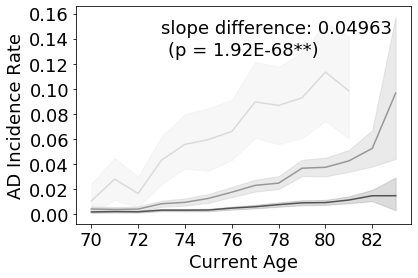

Slope Difference: 0.07509365929774486


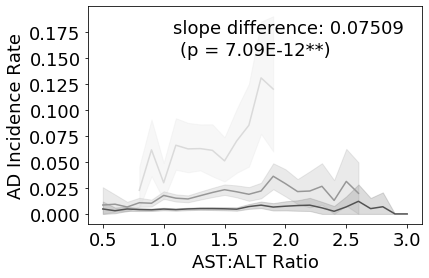

Slope Difference: 0.08326451584782957


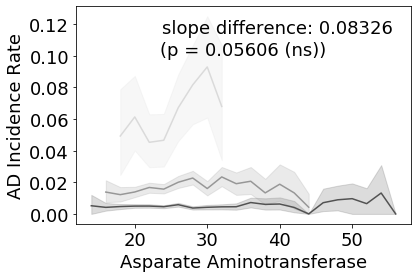

Slope Difference: -0.07374188489659032


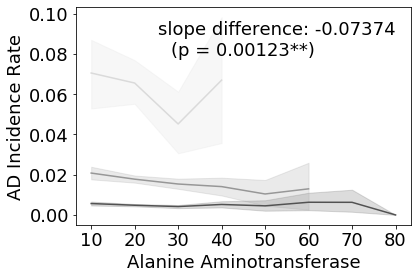

Slope Difference: 0.04341270440932596


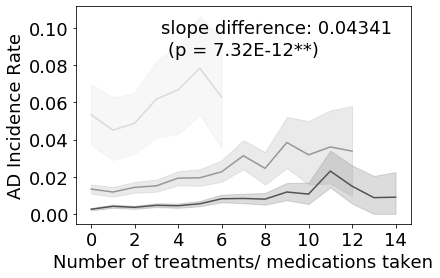

Slope Difference: 0.0649640885199835


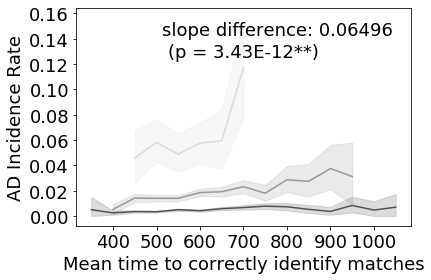

Slope Difference: 0.021245766955541374


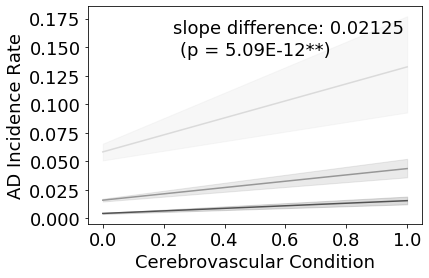

Slope Difference: 0.01074855660098186


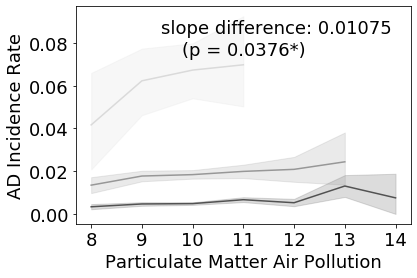

Slope Difference: 0.026701134441089146


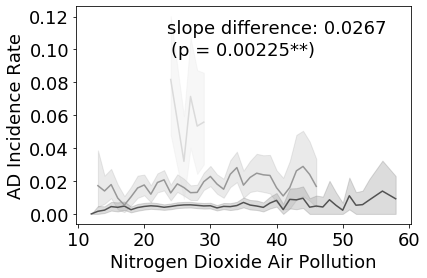

Slope Difference: -0.01191225952469046


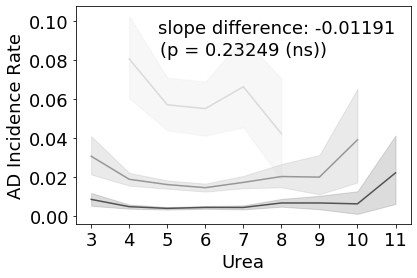

Slope Difference: -0.009417113348696842


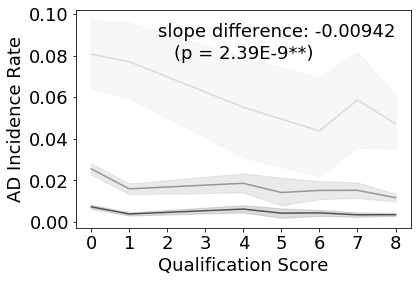

Slope Difference: 0.005697368657167397


In [ ]:

pv_slp=pvalue_slopes(ukb_shap,'Age_Today')
lines_conf('Age_Today','Current Age',df=ukb_shap,minsamp=100,rounded=0,regplot=0,e4e4=1,
          pval=pv_slp[1],slope_diff=pv_slp[0],figord='a')

pv_slp=pvalue_slopes(ukb_shap,'alan_aspar_rat')
lines_conf('alan_aspar_rat','AST:ALT Ratio',df=ukb_shap,minsamp=100,riskscore=0,regplot=0,e4e4=1,
          pval=pv_slp[1],slope_diff=pv_slp[0],figord='b')

pv_slp=pvalue_slopes(ukb_shap,'aspartate_aminotransferase_f30650')
lines_conf('aspartate_aminotransferase_f30650','Asparate Aminotransferase',df=ukb_shap,minsamp=200,
           factdiv=20,riskscore=0,regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='C')

pv_slp=pvalue_slopes(ukb_shap,'alanine_aminotransferase_f30620')
lines_conf('alanine_aminotransferase_f30620','Alanine Aminotransferase',df=ukb_shap,minsamp=200,rounded=0,
           factdiv=10,regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='d')

pv_slp=pvalue_slopes(ukb_shap,'number_of_treatmentsmedications_taken_f137')
lines_conf('number_of_treatmentsmedications_taken_f137','Number of treatments/ medications taken',
           df=ukb_shap,minsamp=200,regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='e')

pv_slp=pvalue_slopes(ukb_shap,'mean_time_to_correctly_identify_matches_f20023')
lines_conf('mean_time_to_correctly_identify_matches_f20023',\
           'Mean time to correctly identify matches',df=ukb_shap,minsamp=200,rounded=0,
           factdiv=50,regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='f')

pv_slp=pvalue_slopes(ukb_shap,'CERVASCALL_bef')
lines_conf('CERVASCALL_bef','Cerebrovascular Condition',minsamp=100,df=ukb_shap,rounded=1,
           factdiv=1,regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='g')

pv_slp=pvalue_slopes(ukb_shap,'particulate_matter_air_pollution_pm25_2010_f24006')
lines_conf('particulate_matter_air_pollution_pm25_2010_f24006',\
           'Particulate Matter Air Pollution',df=ukb_shap,minsamp=200,rounded=0,factdiv=1,
           regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='h')

pv_slp=pvalue_slopes(ukb_shap,'nitrogen_dioxide_air_pollution_2006_f24017')
lines_conf('nitrogen_dioxide_air_pollution_2006_f24017','Nitrogen Dioxide Air Pollution',
           df=ukb_shap,minsamp=200,rounded=0,factdiv=1,regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='i')

pv_slp=pvalue_slopes(ukb_shap,'urea_f30670')
lines_conf('urea_f30670','Urea',df=ukb_shap,minsamp=200,rounded=0,factdiv=1,
           regplot=0,e4e4=1,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='j')

pv_slp=pvalue_slopes(ukb_shap,'qualif_score')
lines_conf('qualif_score','Qualification Score',df=ukb_shap,minsamp=200,
           rounded=1,regplot=0,e4e4=1,riskscore=0,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='k')

mask_sleep=(ukb_shap['sleeplessness_insomnia_f1200'].isin(['Sometimes','Usually','Prefer not to answer']))
pv_slp=pvalue_slopes(ukb_shap[mask_sleep],'sleep_duration_f1160')
lines_conf('sleep_duration_f1160','Sleep Duration',df=ukb_shap[mask_sleep],
           minsamp=200,rounded=10,regplot=0,e4e4=1,riskscore=0,
           pval=pv_slp[1],slope_diff=pv_slp[0],figord='l')

Slope Difference: 0.04786135972902645


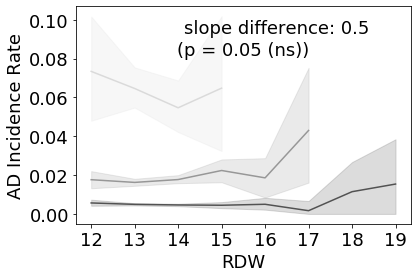

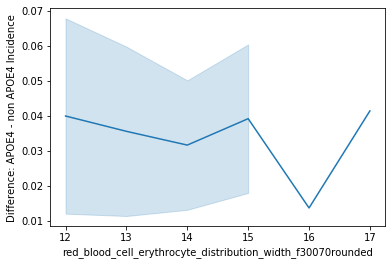

In [203]:
pv_slp=pvalue_slopes(ukb_shap,'red_blood_cell_erythrocyte_distribution_width_f30070')
lines_conf('red_blood_cell_erythrocyte_distribution_width_f30070','RDW',df=ukb_shap,
           minsamp=100,rounded=0,regplot=0,e4e4=1,riskscore=0)


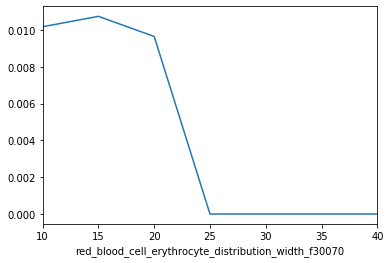

In [49]:
ukb_shap[(ukb_shap['APOE']==1)].groupby('red_blood_cell_erythrocyte_distribution_width_f30070')['AD'].mean().plot()

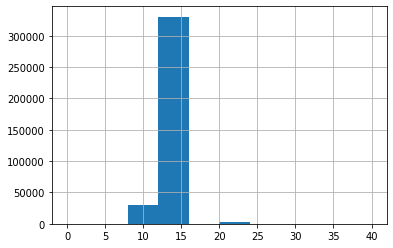

In [48]:
ukb_shap[(ukb_shap['APOE']==0)]['red_blood_cell_erythrocyte_distribution_width_f30070'].hist()